In [3]:
# =========================
# CELL 1: CONFIG & IMPORTS
# =========================
import os, time
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F  # functional kept as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -- USER CONFIG --
INPATH = '/kaggle/input/graphwavenet'   # update if different
OUTPATH = '/kaggle/working'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparams (tweak as needed)
L = 4                      # history length
BATCH = 64
EPOCHS = 40
LR = 1e-3
PATIENCE = 6
HIDDEN_TEMP = 64           # temporal conv channels
GCN_HID = 128              # graph conv hidden dim
DROPOUT = 0.2
K_DIFF = 2                 # diffusion depth in graph conv
SEED = 42

os.makedirs(OUTPATH, exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)

print("INPATH:", INPATH, "OUTPATH:", OUTPATH, "DEVICE:", DEVICE)


# ================================================
# CELL 2: LOAD PREPROCESSED FILES & BUILD ADJ MATRIX
# ================================================
x_path = os.path.join(INPATH, "X_tensor.npy")
y_path = os.path.join(INPATH, "Y_tensor.npy")
zone_path = os.path.join(INPATH, "zone_list.npy")
edges_path = os.path.join(INPATH, "graph_edges.csv")

assert os.path.exists(x_path), f"{x_path} not found"
assert os.path.exists(y_path), f"{y_path} not found"
assert os.path.exists(zone_path), f"{zone_path} not found"
assert os.path.exists(edges_path), f"{edges_path} not found"

X_tensor = np.load(x_path)   # (T, Z, F)
Y_tensor = np.load(y_path)   # (T, Z)
zone_list = np.load(zone_path, allow_pickle=True)

T, Z, F_count = X_tensor.shape
print("Loaded shapes -> X:", X_tensor.shape, "Y:", Y_tensor.shape, "zones:", len(zone_list))

# read edges csv: try to find src/dst columns, else first two cols
edges_df = pd.read_csv(edges_path)
if {'src_idx','dst_idx'}.issubset(edges_df.columns):
    src = edges_df['src_idx'].astype(int).values
    dst = edges_df['dst_idx'].astype(int).values
else:
    src = edges_df.iloc[:,0].astype(int).values
    dst = edges_df.iloc[:,1].astype(int).values

# build symmetric adjacency (no weights besides 1)
A = sp.coo_matrix((np.ones(len(src)), (src, dst)), shape=(Z, Z))
A = A + A.T
A.data = np.ones_like(A.data)
A.setdiag(0)
A.eliminate_zeros()
print("Edges loaded:", A.nnz, "nonzero entries (symmetric)")

# normalized symmetric adjacency: D^-1/2 A D^-1/2
A = A.tocoo()
deg = np.array(A.sum(axis=1)).flatten()
deg_inv_sqrt = np.power(deg, -0.5, where=deg>0)
deg_inv_sqrt[~np.isfinite(deg_inv_sqrt)] = 0.0
D_inv_sqrt = sp.diags(deg_inv_sqrt)
A_norm = D_inv_sqrt.dot(A).dot(D_inv_sqrt).tocoo()

# convert to dense torch (Z small)
A_norm_dense = torch.from_numpy(A_norm.toarray()).float().to(DEVICE)   # (Z,Z)
print("A_norm shape:", A_norm_dense.shape)


# ===================================================
# CELL 3: BUILD SEQUENCES (N, Z, F, L) & TRAIN/VAL/TEST SPLIT
# ===================================================
assert X_tensor.ndim == 3, "X_tensor must be (T,Z,F)"
T_, Z_, F_ = X_tensor.shape
assert (T_, Z_, F_) == (T, Z, F_count)

# Create seq_X (N, Z, F, L) and seq_Y (N, Z) with target at t+L
N = T - L
seq_X = np.zeros((N, Z, F_count, L), dtype=np.float32)
seq_Y = np.zeros((N, Z), dtype=np.float32)
for i in range(N):
    # take slices [i : i+L) along time axis
    # X_tensor[i:i+L, :, :] shape => (L, Z, F) -> transpose to (Z, F, L)
    seq_X[i] = X_tensor[i:i+L, :, :].transpose(1,2,0)
    seq_Y[i] = Y_tensor[i+L, :]  # target at t+L

print("seq_X shape:", seq_X.shape, "seq_Y shape:", seq_Y.shape, "N:", N)

# temporal split: 70/15/15
n_train = int(0.7 * N)
n_val = int(0.15 * N)
n_test = N - n_train - n_val
train_idx = np.arange(0, n_train)
val_idx = np.arange(n_train, n_train + n_val)
test_idx = np.arange(n_train + n_val, N)
print("Train/Val/Test sizes:", len(train_idx), len(val_idx), len(test_idx))


# =============================
# CELL 4: DATASET & DATALOADERS
# =============================
class STDataset(Dataset):
    def __init__(self, seq_X, seq_Y, idxs):
        self.seq_X = seq_X
        self.seq_Y = seq_Y
        self.idxs = idxs
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, i):
        t = self.idxs[i]
        x = torch.from_numpy(self.seq_X[t]).float()   # (Z, F, L)
        y = torch.from_numpy(self.seq_Y[t]).float()   # (Z,)
        return x, y

train_ds = STDataset(seq_X, seq_Y, train_idx)
val_ds = STDataset(seq_X, seq_Y, val_idx)
test_ds = STDataset(seq_X, seq_Y, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, pin_memory=True)

print("DataLoaders ready. BATCH:", BATCH)
xb, yb = next(iter(train_loader))
print("Example batch shapes -> xb:", xb.shape, "yb:", yb.shape)  # (B, Z, F, L), (B, Z)


# ===========================================
# CELL 5: MODEL DEFINITION (no PyG dependency)
# ===========================================
class DiffusionGraphConvVec(nn.Module):
    def __init__(self, in_ch, out_ch, K=2):
        super().__init__()
        self.K = K
        self.linears = nn.ModuleList([nn.Linear(in_ch, out_ch) for _ in range(K+1)])
    def forward(self, x, A_norm):
        # x: (B, Z, C)
        B, Z, C = x.shape
        out = torch.zeros(B, Z, self.linears[0].out_features, device=x.device)
        Xk = x
        for k in range(self.K + 1):
            t = self.linears[k](Xk.reshape(B*Z, C)).reshape(B, Z, -1)
            out = out + t
            if k < self.K:
                # Xk_next[b] = A_norm @ Xk[b] for each b (vectorized via einsum)
                Xk = torch.einsum('ij,bjk->bik', A_norm, Xk)  # (B,Z,C)
        return out

class TemporalGraphWaveNet(nn.Module):
    def __init__(self, F_in, L_hist, tmp_channels=64, gcn_hidden=128, K=2, dropout=0.2):
        super().__init__()
        self.F_in = F_in
        self.L = L_hist
        # Conv1d expects input (batch, channels, length)
        self.temp_conv1 = nn.Conv1d(in_channels=F_in, out_channels=tmp_channels, kernel_size=3, padding=1, dilation=1)
        self.temp_conv2 = nn.Conv1d(in_channels=tmp_channels, out_channels=tmp_channels, kernel_size=3, padding=2, dilation=2)
        self.temp_conv3 = nn.Conv1d(in_channels=tmp_channels, out_channels=tmp_channels, kernel_size=3, padding=4, dilation=4)
        self.proj = nn.Linear(tmp_channels, gcn_hidden)
        self.gconv = DiffusionGraphConvVec(in_ch=gcn_hidden, out_ch=gcn_hidden, K=K)
        self.head = nn.Sequential(nn.ReLU(), nn.Dropout(dropout), nn.Linear(gcn_hidden, 1))

    def forward(self, x_seq, A_norm):
        # x_seq: (B, Z, F, L)
        B, Z, C_feat, L = x_seq.shape                  # <<-- DON'T name this 'F' (would shadow module F)
        x = x_seq.reshape(B*Z, C_feat, L)              # (B*Z, channels, length) for Conv1d
        x = self.temp_conv1(x)                         # -> (B*Z, tmp_channels, L)
        x = F.relu(x)
        x = self.temp_conv2(x)
        x = F.relu(x)
        x = self.temp_conv3(x)
        x = F.relu(x)
        x = x.mean(dim=2)                              # global pool over time -> (B*Z, tmp_channels)
        x = x.reshape(B, Z, -1)                        # (B, Z, tmp_channels)
        x = self.proj(x)                               # (B, Z, gcn_hidden)
        x = self.gconv(x, A_norm)                      # (B, Z, gcn_hidden)
        out = self.head(x).squeeze(-1)                 # (B, Z)
        return out

# instantiate model
model = TemporalGraphWaveNet(
    F_in=F_count,
    L_hist=L,
    tmp_channels=HIDDEN_TEMP,
    gcn_hidden=GCN_HID,
    K=K_DIFF,
    dropout=DROPOUT
).to(DEVICE)

print(model)


# ====================
# CELL 6: TRAIN LOOP
# ====================
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.MSELoss()

best_val = float('inf')
best_state = None
patience_ct = 0
start_time = time.time()

def eval_loader(loader):
    model.eval()
    preds_all = []
    trues_all = []
    with torch.no_grad():
        for xb, yb in loader:
            # xb: (B, Z, F, L) tensor already
            xb = xb.to(DEVICE)    # (B, Z, F, L)
            yb = yb.to(DEVICE)    # (B, Z)
            out = model(xb, A_norm_dense)   # (B, Z)
            preds_all.append(out.detach().cpu().numpy().reshape(-1))
            trues_all.append(yb.detach().cpu().numpy().reshape(-1))
    if len(preds_all) == 0:
        return {"mae": np.nan, "rmse": np.nan}
    preds = np.concatenate(preds_all)
    trues = np.concatenate(trues_all)
    return {"mae": mean_absolute_error(trues, preds), "rmse": mean_squared_error(trues, preds, squared=False)}

print("Beginning training epochs:", EPOCHS)
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)   # (B, Z, F, L)
        yb = yb.to(DEVICE)   # (B, Z)
        optimizer.zero_grad()
        out = model(xb, A_norm_dense)    # (B, Z)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_losses.append(loss.item())

    val_metrics = eval_loader(val_loader)
    val_mae = val_metrics["mae"]
    avg_train_loss = np.mean(train_losses) if train_losses else np.nan
    print(f"Epoch {epoch:02d} train_loss={avg_train_loss:.4f} val_mae={val_mae:.4f} time={(time.time() - t0):.1f}s")
    scheduler.step(val_mae)

    # early stopping
    if val_mae < best_val:
        best_val = val_mae
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_ct = 0
        print(" New best val MAE:", best_val)
    else:
        patience_ct += 1
        if patience_ct >= PATIENCE:
            print("Early stopping. Patience exceeded.")
            break

# restore best
if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), os.path.join(OUTPATH, "gnn_model_gwn.pt"))
print("Training finished. elapsed:", time.time() - start_time)
print("Saved model to", os.path.join(OUTPATH, "gnn_model_gwn.pt"))


# =========================================
# CELL 7: TEST EVAL & SAVE PREDICTIONS
# =========================================
model.eval()
rows = []

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        out = model(xb, A_norm_dense).cpu().numpy()   # (B, Z)
        true = yb.cpu().numpy()
        batch_size_now = out.shape[0]
        for b in range(batch_size_now):
            sample_global_idx = test_idx[i * BATCH + b] if (i * BATCH + b) < len(test_idx) else -1
            for node in range(Z):
                rows.append({
                    "zone": str(zone_list[node]),
                    "sample_idx": int(sample_global_idx),
                    "pred_bookings": float(out[b, node]),
                    "true_bookings": float(true[b, node])
                })

preds_df = pd.DataFrame(rows)
preds_path = os.path.join(OUTPATH, "gnn_predictions_gwn.csv")
preds_df.to_csv(preds_path, index=False)
print("Saved predictions to", preds_path)

mae = mean_absolute_error(preds_df["true_bookings"], preds_df["pred_bookings"])
rmse = mean_squared_error(preds_df["true_bookings"], preds_df["pred_bookings"], squared=False)
print("TEST MAE:", mae, "RMSE:", rmse)
display(preds_df.head(20))


# =========================
# CELL 8: DIAGNOSTICS & NOTES
# =========================
print("Model file:", os.path.join(OUTPATH, "gnn_model_gwn.pt"), "exists:", os.path.exists(os.path.join(OUTPATH, "gnn_model_gwn.pt")))
print("Predictions file:", preds_path, "exists:", os.path.exists(preds_path))
print("graph_edges.csv present:", os.path.exists(edges_path))
print("Zone count:", Z, "Feature count:", F_count, "History L:", L)
print("If too slow or OOM: reduce BATCH, HIDDEN_TEMP, GCN_HID, or L.")


INPATH: /kaggle/input/graphwavenet OUTPATH: /kaggle/working DEVICE: cuda
Loaded shapes -> X: (70075, 67, 10) Y: (70075, 67) zones: 67
Edges loaded: 504 nonzero entries (symmetric)
A_norm shape: torch.Size([67, 67])
seq_X shape: (70071, 67, 10, 4) seq_Y shape: (70071, 67) N: 70071
Train/Val/Test sizes: 49049 10510 10512
DataLoaders ready. BATCH: 64
Example batch shapes -> xb: torch.Size([64, 67, 10, 4]) yb: torch.Size([64, 67])
TemporalGraphWaveNet(
  (temp_conv1): Conv1d(10, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (temp_conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (temp_conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  (proj): Linear(in_features=64, out_features=128, bias=True)
  (gconv): DiffusionGraphConvVec(
    (linears): ModuleList(
      (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (head): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.2, inplace=False)
    (2): 

,zone,sample_idx,pred_bookings,true_bookings
0,8986d880d77ffff,59559,487.328552,476.181854
1,8986d882c0bffff,59559,338.569031,322.527435
2,8986d882e3bffff,59559,277.003052,313.196167
3,8986d88412bffff,59559,256.634155,264.367249
4,8986d88412fffff,59559,166.017456,199.273544
5,8986d88440bffff,59559,581.621155,608.123413
6,8986d88449bffff,59559,576.334045,529.688965
7,8986d884537ffff,59559,142.431305,152.436981
8,8986d88454bffff,59559,248.489899,254.863693
9,8986d88454fffff,59559,412.171997,461.934906


Model file: /kaggle/working/gnn_model_gwn.pt exists: True
Predictions file: /kaggle/working/gnn_predictions_gwn.csv exists: True
graph_edges.csv present: True
Zone count: 67 Feature count: 10 History L: 4
If too slow or OOM: reduce BATCH, HIDDEN_TEMP, GCN_HID, or L.


Rows: 704304
MAE: 38.9770   RMSE: 67.2634


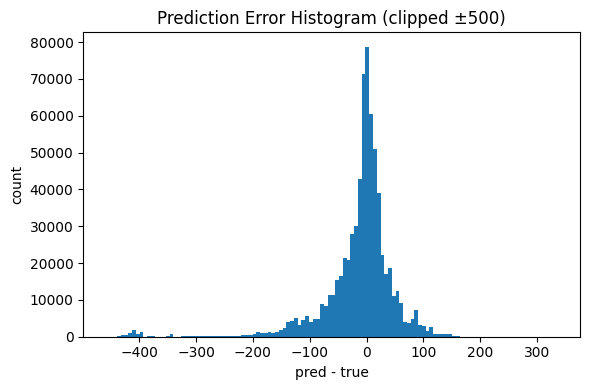

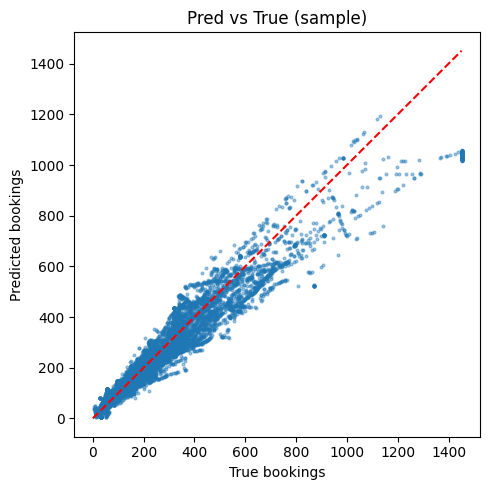

Top 10 worst zones by mean absolute error:
                       mean  count
zone                              
8986dd493cbffff  263.205236  10512
8986d886817ffff  129.905321  10512
8986d886877ffff  107.392991  10512
8986d886e6fffff  106.541972  10512
8986d880d77ffff   83.199065  10512
8986d886aafffff   81.285946  10512
8986d88460fffff   75.060508  10512
8986d886ccfffff   70.324943  10512
8986d88454bffff   68.778779  10512
8986dd49abbffff   68.173493  10512


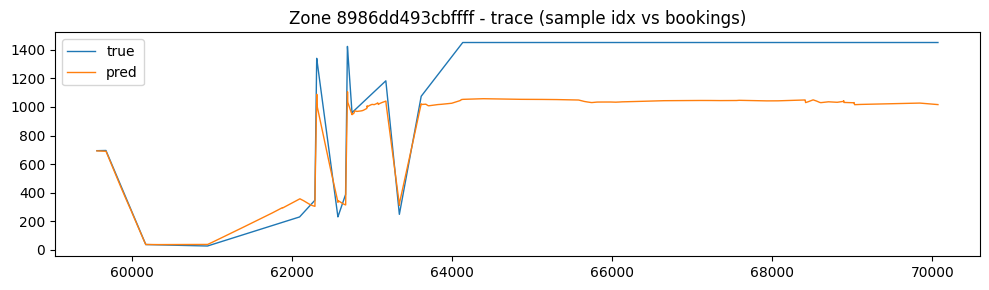

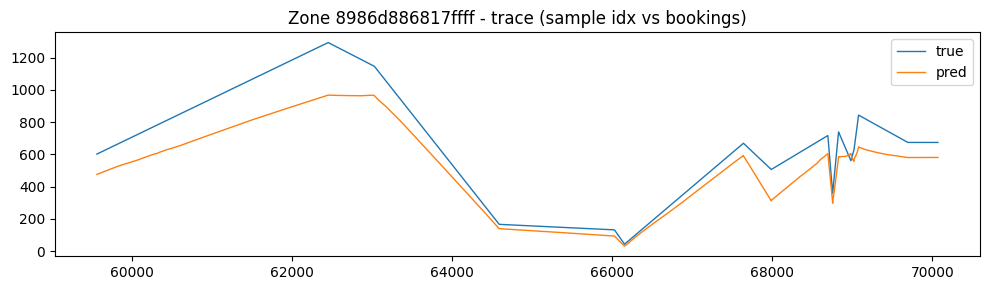

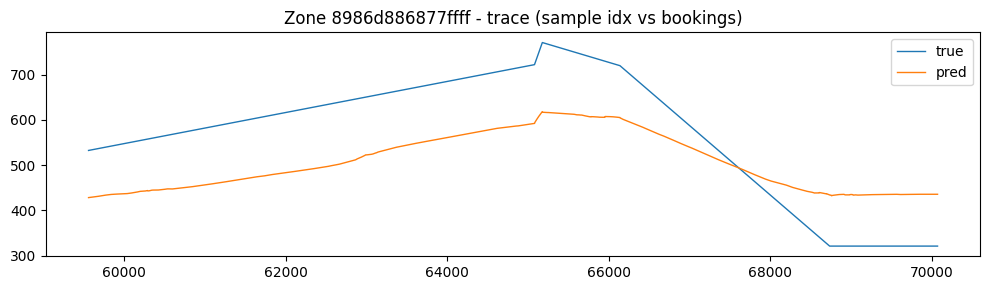

Saved plots to /kaggle/working


In [4]:
# === EVAL & PLOTS ===
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

OUTPATH = '/kaggle/working'
preds_path = os.path.join(OUTPATH, "gnn_predictions_gwn.csv")  # or stgcn preds
assert os.path.exists(preds_path), preds_path + " missing"

df = pd.read_csv(preds_path)
print("Rows:", len(df))
mae = mean_absolute_error(df["true_bookings"], df["pred_bookings"])
rmse = mean_squared_error(df["true_bookings"], df["pred_bookings"], squared=False)
print(f"MAE: {mae:.4f}   RMSE: {rmse:.4f}")

# Error column
df['error'] = df['pred_bookings'] - df['true_bookings']
df['ae'] = df['error'].abs()

# 1. Error histogram
plt.figure(figsize=(6,4))
plt.hist(df['error'].clip(-500,500), bins=120)
plt.title("Prediction Error Histogram (clipped ±500)")
plt.xlabel("pred - true")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(os.path.join(OUTPATH, "error_hist.png"))
plt.show()

# 2. Pred vs True scatter (sample <=10000 points)
sample = df.sample(min(10000, len(df)), random_state=42)
plt.figure(figsize=(5,5))
plt.scatter(sample['true_bookings'], sample['pred_bookings'], s=4, alpha=0.4)
mx = max(sample['true_bookings'].max(), sample['pred_bookings'].max())
plt.plot([0,mx],[0,mx], 'r--')
plt.xlabel("True bookings")
plt.ylabel("Predicted bookings")
plt.title("Pred vs True (sample)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPATH, "pred_vs_true_scatter.png"))
plt.show()

# 3. Worst zones by MAE
zone_err = df.groupby('zone')['ae'].agg(['mean','count']).sort_values('mean', ascending=False)
print("Top 10 worst zones by mean absolute error:")
print(zone_err.head(10))
zone_err.head(10).to_csv(os.path.join(OUTPATH, "worst_zones.csv"))

# 4. Time-series trace for a few zones (select top 3 worst)
top_zones = zone_err.head(3).index.tolist()
for z in top_zones:
    zdf = df[df['zone']==z].sort_values('sample_idx')
    plt.figure(figsize=(10,3))
    plt.plot(zdf['sample_idx'], zdf['true_bookings'], label='true', linewidth=1)
    plt.plot(zdf['sample_idx'], zdf['pred_bookings'], label='pred', linewidth=1)
    plt.title(f"Zone {z} - trace (sample idx vs bookings)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPATH, f"trace_zone_{z}.png"))
    plt.show()

print("Saved plots to", OUTPATH)


In [7]:
# ============================
#   FULL TRAIN + COMPARE Ls
# ============================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------ TRAIN FUNCTION ------------
def train_and_eval(model, train_loader, val_loader, test_loader, save_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    best = float('inf')
    patience = 0

    print("\n===============================")
    print(f"TRAINING MODEL: {save_name}")
    print("===============================")

    for epoch in range(1, EPOCHS + 1):
        model.train()
        batch_losses = []

        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            pred = model(xb, A_norm_dense)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        # ---- Validation ----
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                out = model(xb, A_norm_dense)
                preds.append(out.cpu().numpy().reshape(-1))
                trues.append(yb.cpu().numpy().reshape(-1))

        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        val_mae = mean_absolute_error(trues, preds)

        print(f"Epoch {epoch:02d}   train_loss={np.mean(batch_losses):.3f}   val_MAE={val_mae:.3f}")

        # Early stopping
        if val_mae < best:
            best = val_mae
            patience = 0
            torch.save(model.state_dict(), f"/kaggle/working/{save_name}.pt")
            print("   ✓ Saved best model")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("   EARLY STOPPING")
                break

    # ===========================
    #         TEST EVAL
    # ===========================
    print(f"\nEvaluating best saved model for {save_name}…")
    model.load_state_dict(torch.load(f"/kaggle/working/{save_name}.pt"))
    model.eval()

    rows = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb, A_norm_dense).cpu().numpy()
            yb = yb.cpu().numpy()
            B = out.shape[0]
            for b in range(B):
                for z in range(Z):
                    rows.append({
                        "zone": str(zone_list[z]),
                        "true": float(yb[b, z]),
                        "pred": float(out[b, z])
                    })

    df = pd.DataFrame(rows)
    df.to_csv(f"/kaggle/working/{save_name}_preds.csv", index=False)

    test_mae = mean_absolute_error(df["true"], df["pred"])
    test_rmse = mean_squared_error(df["true"], df["pred"], squared=False)

    print(f"TEST RESULTS →  MAE={test_mae:.4f}   RMSE={test_rmse:.4f}")

    return test_mae, test_rmse


# ===========================================
#        FUNCTION TO REBUILD SEQUENCES
# ===========================================
def rebuild_sequences(L):
    N = T - L
    seq_X = np.zeros((N, Z, F_count, L), dtype=np.float32)
    seq_Y = np.zeros((N, Z), dtype=np.float32)
    for i in range(N):
        seq_X[i] = X_tensor[i:i+L].transpose(1,2,0)
        seq_Y[i] = Y_tensor[i+L]

    tr = int(0.7*N)
    va = int(0.85*N)

    train_ds = STDataset(seq_X, seq_Y, np.arange(0, tr))
    val_ds   = STDataset(seq_X, seq_Y, np.arange(tr, va))
    test_ds  = STDataset(seq_X, seq_Y, np.arange(va, N))

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader


# =============================
#   RUN ALL 3 MODELS: L=4,8,12
# =============================

results = {}

# ---- L=4 ---- already your main dataset
train_loader4, val_loader4, test_loader4 = train_loader, val_loader, test_loader
model4 = TemporalGraphWaveNet(F_count, 4, HIDDEN_TEMP, GCN_HID, K_DIFF, DROPOUT).to(DEVICE)
mae4, rmse4 = train_and_eval(model4, train_loader4, val_loader4, test_loader4, "gwn_L4")
results["L4"] = (mae4, rmse4)

# ---- L=8 ----
train_loader8, val_loader8, test_loader8 = rebuild_sequences(8)
model8 = TemporalGraphWaveNet(F_count, 8, HIDDEN_TEMP, GCN_HID, K_DIFF, DROPOUT).to(DEVICE)
mae8, rmse8 = train_and_eval(model8, train_loader8, val_loader8, test_loader8, "gwn_L8")
results["L8"] = (mae8, rmse8)

# ---- L=12 ----
train_loader12, val_loader12, test_loader12 = rebuild_sequences(12)
model12 = TemporalGraphWaveNet(F_count, 12, HIDDEN_TEMP, GCN_HID, K_DIFF, DROPOUT).to(DEVICE)
mae12, rmse12 = train_and_eval(model12, train_loader12, val_loader12, test_loader12, "gwn_L12")
results["L12"] = (mae12, rmse12)


# =============================
#     PRINT FINAL COMPARISON
# =============================
print("\n====================================")
print("        FINAL MODEL COMPARISON")
print("====================================")
for key, (mae, rmse) in results.items():
    print(f"{key} →  MAE={mae:.3f}   RMSE={rmse:.3f}")

print("\nAll prediction files saved to /kaggle/working/")



TRAINING MODEL: gwn_L4
Epoch 01   train_loss=6092.657   val_MAE=34.801
   ✓ Saved best model
Epoch 02   train_loss=3324.091   val_MAE=36.004
Epoch 03   train_loss=3208.574   val_MAE=38.165
Epoch 04   train_loss=3091.619   val_MAE=34.172
   ✓ Saved best model
Epoch 05   train_loss=3042.906   val_MAE=34.312
Epoch 06   train_loss=2945.075   val_MAE=33.980
   ✓ Saved best model
Epoch 07   train_loss=2912.467   val_MAE=36.277
Epoch 08   train_loss=2830.040   val_MAE=32.534
   ✓ Saved best model
Epoch 09   train_loss=2780.133   val_MAE=33.518
Epoch 10   train_loss=2665.526   val_MAE=34.391
Epoch 11   train_loss=2633.715   val_MAE=31.926
   ✓ Saved best model
Epoch 12   train_loss=2626.767   val_MAE=32.019
Epoch 13   train_loss=2464.219   val_MAE=36.700
Epoch 14   train_loss=2400.272   val_MAE=32.069
Epoch 15   train_loss=2319.560   val_MAE=32.723
Epoch 16   train_loss=2394.771   val_MAE=31.444
   ✓ Saved best model
Epoch 17   train_loss=2185.205   val_MAE=32.505
Epoch 18   train_loss=2177.6

Loaded /kaggle/working/gwn_L4_preds.csv

===================== gwn_L4 =====================
MAE = 35.244   RMSE = 62.583

Top 10 worst zones by MAE:
zone
8986dd493cbffff    241.763606
8986d88460fffff    115.300047
8986d886817ffff    105.573100
8986d886e6fffff     98.523987
8986dd49abbffff     78.284832
8986d880d77ffff     68.379406
8986d886877ffff     68.242285
8986d88626fffff     64.891301
8986d882c0bffff     61.098547
8986dd4904fffff     60.534848
Name: ae, dtype: float64


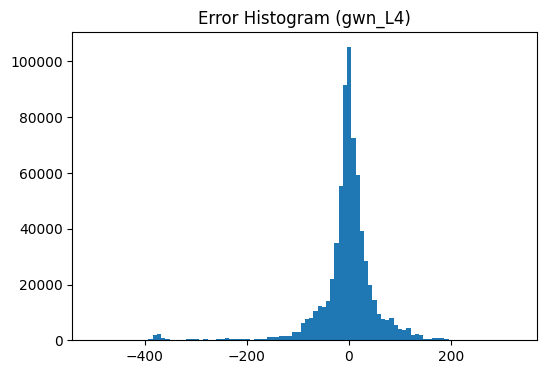

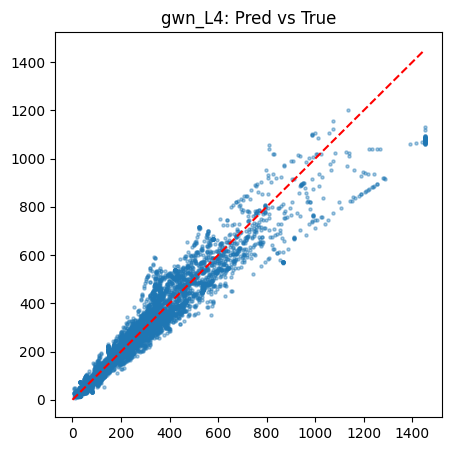

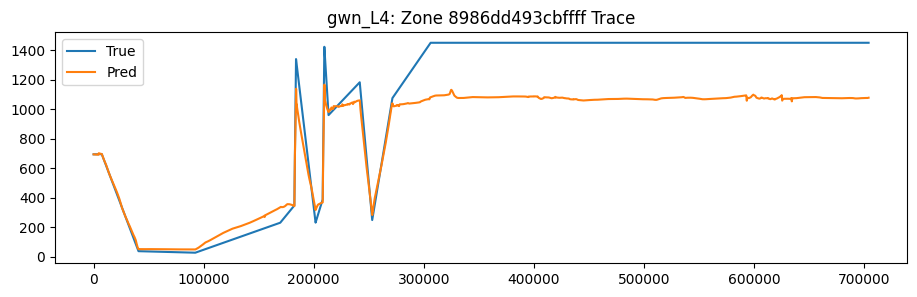

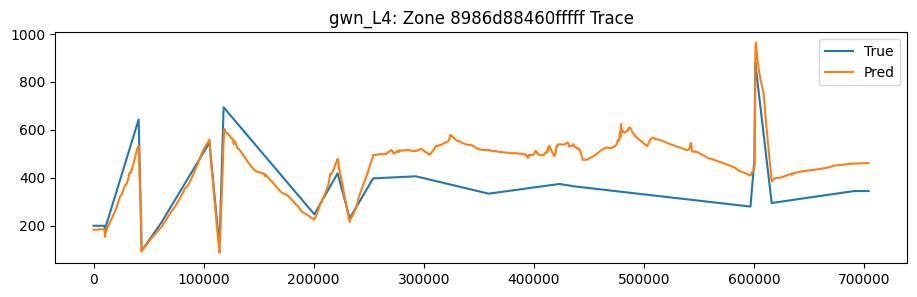

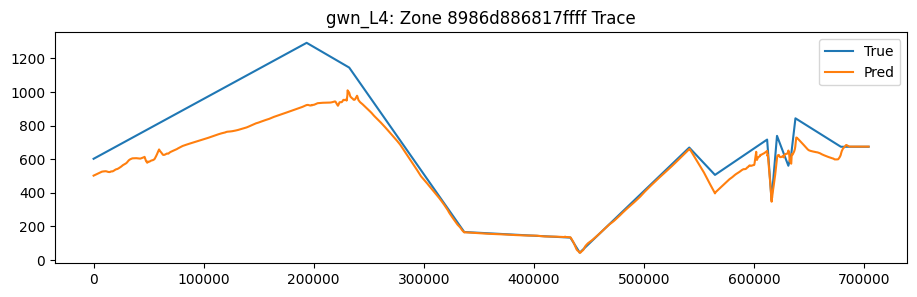

Loaded /kaggle/working/gwn_L8_preds.csv

===================== gwn_L8 =====================
MAE = 34.966   RMSE = 60.107

Top 10 worst zones by MAE:
zone
8986dd493cbffff    234.872809
8986d886817ffff    114.251311
8986d886e6fffff     98.024819
8986d886877ffff     96.441279
8986d88460fffff     93.622679
8986dd49abbffff     64.556833
8986d880d77ffff     64.349370
8986d882c0bffff     64.331847
8986dd4904fffff     58.498901
8986d88454bffff     54.626988
Name: ae, dtype: float64


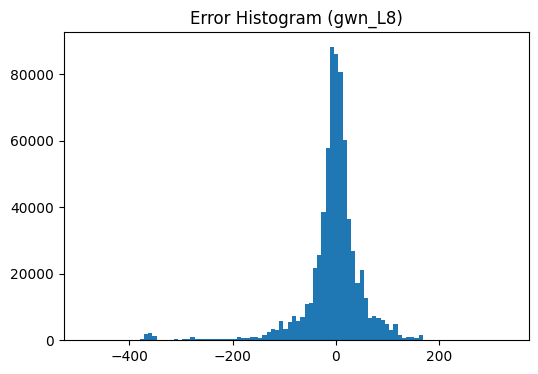

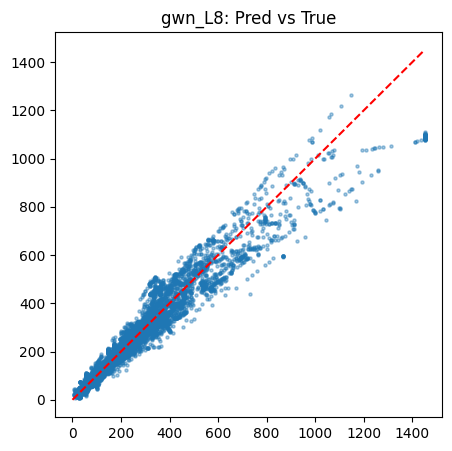

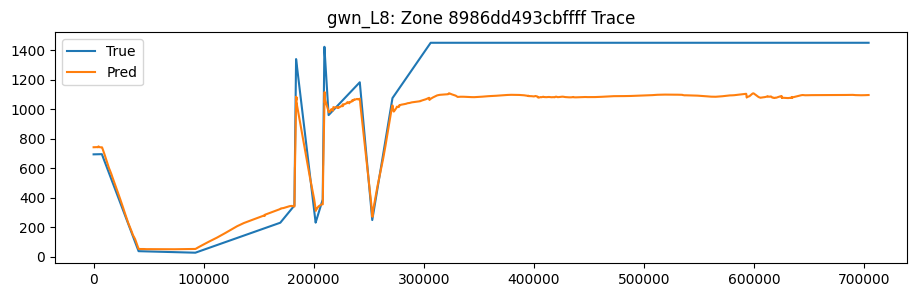

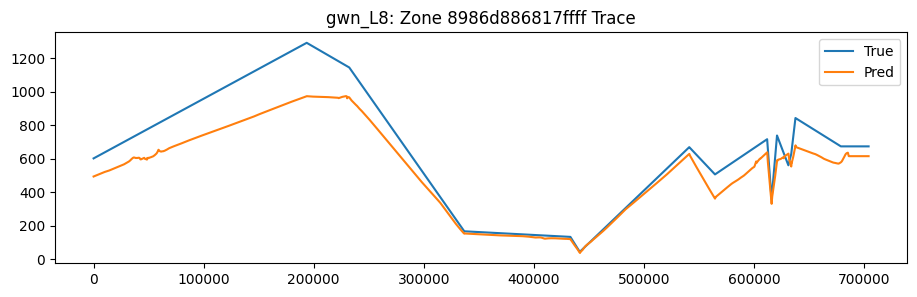

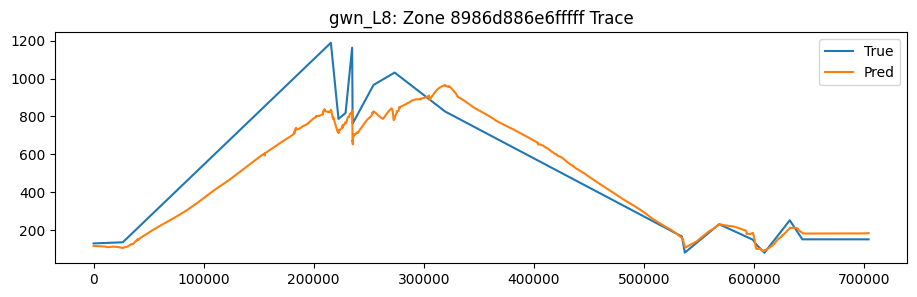

Loaded /kaggle/working/gwn_L12_preds.csv

===================== gwn_L12 =====================
MAE = 34.278   RMSE = 61.326

Top 10 worst zones by MAE:
zone
8986dd493cbffff    242.116929
8986d886817ffff    112.398590
8986d886e6fffff     94.726366
8986d88460fffff     77.133155
8986d880d77ffff     71.266171
8986d886877ffff     69.530540
8986dd49abbffff     68.482356
8986d882c0bffff     65.831736
8986d88454bffff     64.453155
8986d88454fffff     59.463049
Name: ae, dtype: float64


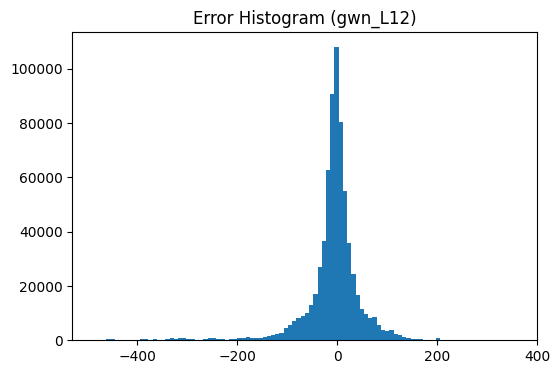

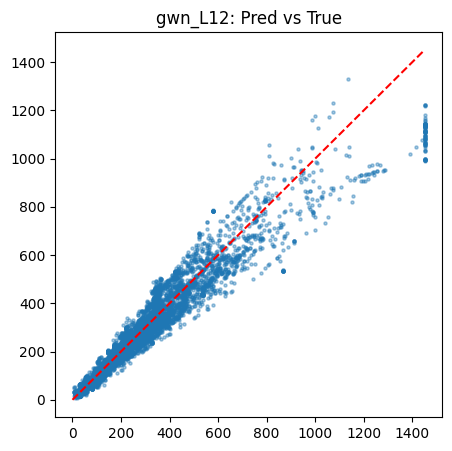

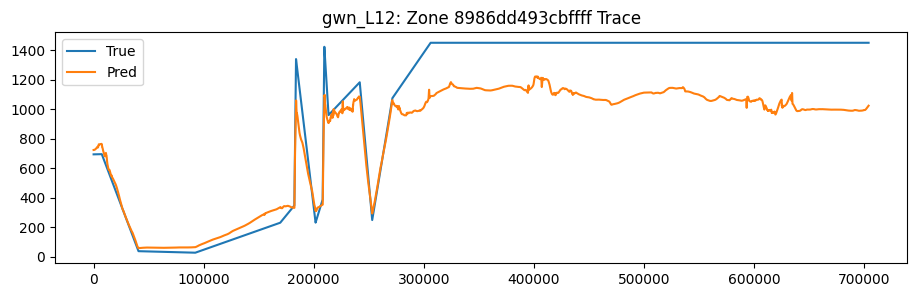

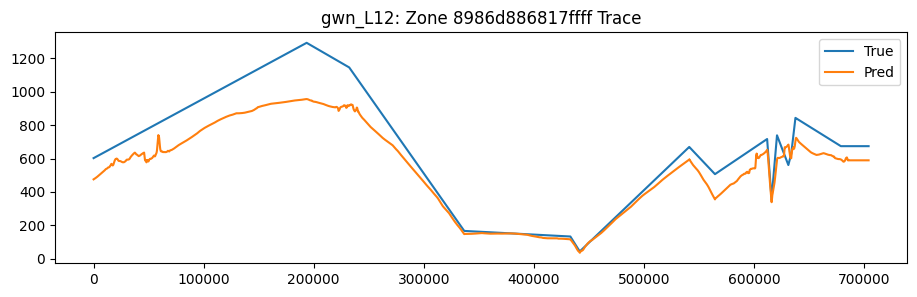

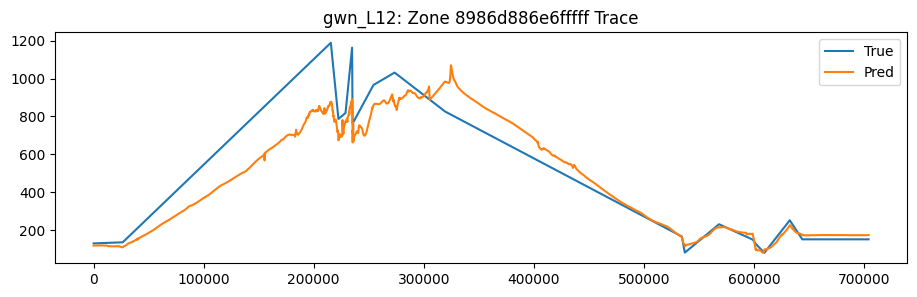


All plots saved + displayed successfully!
Saved files in: /kaggle/working


In [10]:
# =========================================================
#  SAFE PLOTS + NOTEBOOK DISPLAY FOR L = 4, 8, 12
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

OUTPATH = "/kaggle/working"
plt.rcParams["figure.figsize"] = (6,4)

def load_preds(model_tag):
    path = f"{OUTPATH}/{model_tag}_preds.csv"
    if not os.path.exists(path):
        print(f"❌ Missing file: {path}")
        return None
    print(f"Loaded {path}")
    df = pd.read_csv(path)

    # ---------- AUTO-FIX COLUMN NAMES ----------
    rename_map = {}

    # Try all known variants:
    if "true" in df.columns: rename_map["true"] = "true_bookings"
    if "pred" in df.columns: rename_map["pred"] = "pred_bookings"

    if "y_true" in df.columns: rename_map["y_true"] = "true_bookings"
    if "y_pred" in df.columns: rename_map["y_pred"] = "pred_bookings"

    if "true_bookings" not in df.columns and "actual" in df.columns:
        rename_map["actual"] = "true_bookings"
    if "pred_bookings" not in df.columns and "forecast" in df.columns:
        rename_map["forecast"] = "pred_bookings"

    df = df.rename(columns=rename_map)

    # Final sanity check
    required = ["zone", "true_bookings", "pred_bookings"]
    for col in required:
        if col not in df.columns:
            raise ValueError(f"❌ Column '{col}' missing in {path}. Available: {df.columns.tolist()}")

    return df


def make_plots(df, label):
    print(f"\n===================== {label} =====================")
    
    # --- Metrics ---
    mae = mean_absolute_error(df["true_bookings"], df["pred_bookings"])
    rmse = mean_squared_error(df["true_bookings"], df["pred_bookings"], squared=False)
    print(f"MAE = {mae:.3f}   RMSE = {rmse:.3f}")

    # Error columns
    df["error"] = df["pred_bookings"] - df["true_bookings"]
    df["ae"] = df["error"].abs()

    # synthetic index if missing
    if "sample_idx" not in df.columns:
        df = df.copy()
        df["sample_idx"] = np.arange(len(df))

    # --- Worst zones ---
    zone_err = df.groupby("zone")["ae"].mean().sort_values(ascending=False)
    print("\nTop 10 worst zones by MAE:")
    print(zone_err.head(10))

    # --- Histogram ---
    plt.figure()
    plt.hist(df["error"].clip(-500,500), bins=100)
    plt.title(f"Error Histogram ({label})")
    plt.savefig(os.path.join(OUTPATH, f"{label}_error_hist.png"))
    plt.show()

    # --- Pred vs True Scatter ---
    sample = df.sample(min(8000, len(df)), random_state=42)
    plt.figure(figsize=(5,5))
    plt.scatter(sample["true_bookings"], sample["pred_bookings"], s=5, alpha=0.4)
    mx = max(sample["true_bookings"].max(), sample["pred_bookings"].max())
    plt.plot([0,mx],[0,mx],'r--')
    plt.title(f"{label}: Pred vs True")
    plt.savefig(os.path.join(OUTPATH, f"{label}_pred_vs_true.png"))
    plt.show()

    # --- Time traces for 3 worst zones ---
    worst3 = zone_err.head(3).index.tolist()
    for z in worst3:
        zdf = df[df["zone"] == z].sort_values("sample_idx")
        plt.figure(figsize=(11,3))
        plt.plot(zdf["sample_idx"], zdf["true_bookings"], label="True")
        plt.plot(zdf["sample_idx"], zdf["pred_bookings"], label="Pred")
        plt.title(f"{label}: Zone {z} Trace")
        plt.legend()
        plt.savefig(os.path.join(OUTPATH, f"{label}_trace_zone_{z}.png"))
        plt.show()


# =========================================================
# RUN FOR ALL 3 MODELS
# =========================================================
models = ["gwn_L4", "gwn_L8", "gwn_L12"]

for tag in models:
    df = load_preds(tag)
    if df is not None:
        make_plots(df, tag)

print("\nAll plots saved + displayed successfully!")
print("Saved files in:", OUTPATH)
